In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import tensorflow as tf

import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("C:/Users/Nikita Ayu/BMKG/enso.csv", sep= ";")['ANOM'].values.reshape(-1, 1)

In [3]:
# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(df)

In [4]:
def prepare_data(df, time_steps):
    X, y = [], []
    for i in range(len(df) - time_steps):
        a = df[i:(i + time_steps), 0]
        X.append(a)
        y.append(df[i + time_steps, 0])
    return np.array(X), np.array(y)

In [5]:
# Menentukan jumlah langkah waktu (time steps)
time_steps = 12

# Mempersiapkan data sesuai dengan jumlah langkah waktu
X, y = prepare_data(data_normalized, time_steps)

In [6]:
# Membagi data menjadi data latih dan data uji
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [7]:
# Reshape data agar sesuai dengan input LSTM (jumlah sampel, time steps, fitur)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [8]:
# Membangun model LSTM
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(time_steps, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# Melatih model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
22/22 - 4s - loss: 0.0879 - 4s/epoch - 168ms/step
Epoch 2/50
22/22 - 0s - loss: 0.0197 - 247ms/epoch - 11ms/step
Epoch 3/50
22/22 - 0s - loss: 0.0154 - 254ms/epoch - 12ms/step
Epoch 4/50
22/22 - 0s - loss: 0.0134 - 375ms/epoch - 17ms/step
Epoch 5/50
22/22 - 0s - loss: 0.0113 - 250ms/epoch - 11ms/step
Epoch 6/50
22/22 - 0s - loss: 0.0087 - 241ms/epoch - 11ms/step
Epoch 7/50
22/22 - 0s - loss: 0.0066 - 239ms/epoch - 11ms/step
Epoch 8/50
22/22 - 0s - loss: 0.0064 - 242ms/epoch - 11ms/step
Epoch 9/50
22/22 - 0s - loss: 0.0060 - 247ms/epoch - 11ms/step
Epoch 10/50
22/22 - 0s - loss: 0.0060 - 307ms/epoch - 14ms/step
Epoch 11/50
22/22 - 0s - loss: 0.0057 - 232ms/epoch - 11ms/step
Epoch 12/50
22/22 - 0s - loss: 0.0054 - 242ms/epoch - 11ms/step
Epoch 13/50
22/22 - 0s - loss: 0.0055 - 256ms/epoch - 12ms/step
Epoch 14/50
22/22 - 0s - loss: 0.0052 - 259ms/epoch - 12ms/step
Epoch 15/50
22/22 - 0s - loss: 0.0049 - 266ms/epoch - 12ms/step
Epoch 16/50
22/22 - 0s - loss: 0.0047 - 255ms/epoch

In [10]:
# Melakukan prediksi pada data uji
y_pred = model.predict(X_test)

6/6 [==============================] - 1s 10ms/step


In [11]:
# Denormalisasi hasil prediksi
y_pred_denormalized = scaler.inverse_transform(y_pred)
y_test_denormalized = scaler.inverse_transform(y_test.reshape(-1, 1))

In [12]:

# R2 score
r2 = r2_score(y_test_denormalized, y_pred_denormalized)
print(f'R2 Score: {r2:.4f}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_denormalized, y_pred_denormalized)
print(f'MAE: {mae:.4f}')

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_denormalized, y_pred_denormalized) 
print(f'MSE: {mse:.4f}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse:.4f}')

R2 Score: 0.9825
MAE: 0.0947
MSE: 0.0134
RMSE: 0.1158


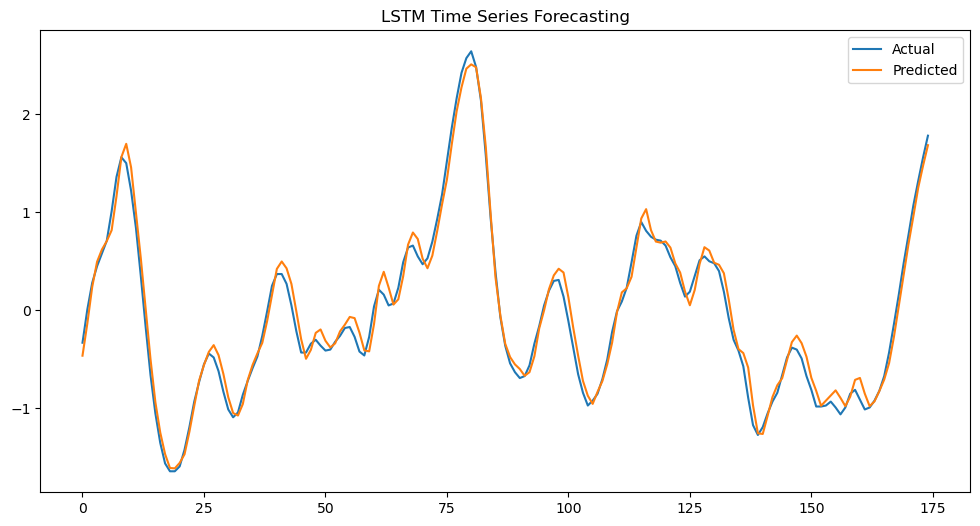

In [13]:
# Visualisasi hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(y_test_denormalized, label='Actual')
plt.plot(y_pred_denormalized, label='Predicted')
plt.legend()
plt.title('LSTM Time Series Forecasting')
plt.show()

In [14]:
input_data = data_normalized[-time_steps:]

# Menambahkan dimensi untuk sesuai dengan input model LSTM
input_data = input_data.reshape((1, time_steps, 1))

In [15]:
# Melakukan prediksi 
future_predictions = []
for i in range(1 * 12): 
    prediction = model.predict(input_data)
    future_predictions.append(prediction)
    # Update input_data dengan nilai prediksi terbaru
    input_data = np.append(input_data[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Denormalisasi hasil prediksi masa depan
future_predictions_denormalized = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


1/1 [==============================] - 0s 47ms/step


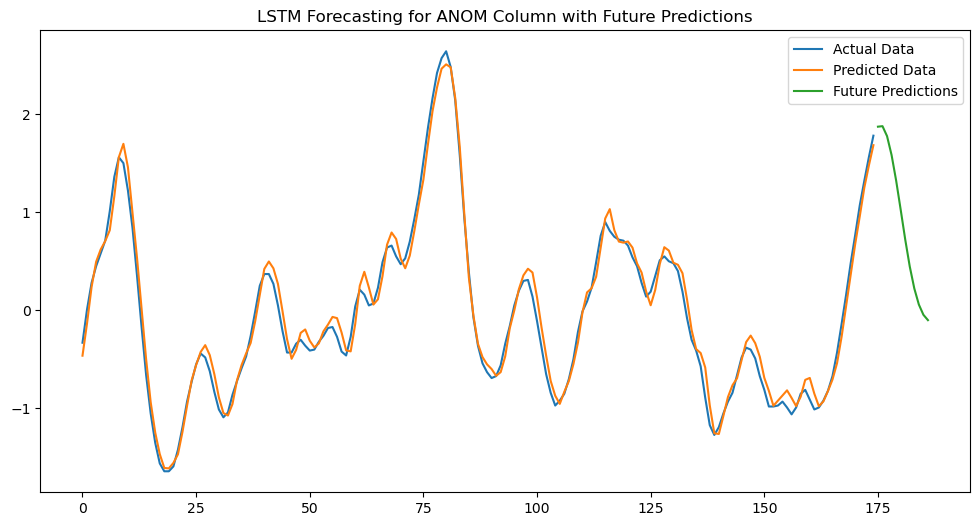

In [16]:
# Visualisasi hasil prediksi masa depan
plt.figure(figsize=(12, 6))
plt.plot(y_test_denormalized, label='Actual Data')
plt.plot(y_pred_denormalized, label='Predicted Data')
plt.plot(range(len(y_test_denormalized), len(y_test_denormalized) + len(future_predictions_denormalized)),
         future_predictions_denormalized, label='Future Predictions')
plt.legend()
plt.title('LSTM Forecasting for ANOM Column with Future Predictions')
plt.show()
